In [3]:
from scipy.special import roots_jacobi, eval_jacobi
import numpy as np
import scipy
import math

import matplotlib.pyplot as plt

### Define functions for D operator:

In [4]:
def int_points(x_range, npts, dx, M):
    
    k = 0
    p_order = npts - 1
    xinterior, w = roots_jacobi(p_order - 1,1,1) # returns interior GLL nodes from range -1 and 1
    GLL_points = np.pad(xinterior, (1, 1), 'constant', constant_values=(-1, 1))
    GLL_dist = np.array([np.abs(GLL_points[0] - value) for value in GLL_points])
    
    return_array = np.zeros([M, npts])
    
    for i in x_range[:-1]:
        array = np.array([i])
        for j in GLL_dist[1:]: 
            scaled_point = ((j / 2) * (dx)) + i # Note: 2 here is the distance from -1 to 1
            array = np.concatenate((array, np.array([scaled_point])))
            
        return_array[k, :] = array
        k = k + 1
    
    return(return_array)

In [5]:
def vandermonde(npts_values, return_type):
    # For the monomial basis: 
    if return_type == 'Monomial':
        return(np.vander(npts_values, increasing = True))
    elif return_type == 'Legendre':
        return(np.polynomial.legendre.legvander(npts_values, len(npts_values) - 1))

In [6]:
def Ld_vandermonde(npts_values): 
    
    LP = np.polynomial.legendre
    v_matrix = np.polynomial.legendre.legvander(npts_values, len(npts_values)-1)
    d_v_matrix = np.zeros_like(v_matrix)

    for i in range(len(npts_values)):
        # Coefficients for the i-th Legendre polynomial (e.g., [0, 0, 1] for P_2)
        coeffs = np.zeros(len(npts_values))
        coeffs[i] = 1

        # Compute the derivative of the i-th Legendre polynomial
        deriv_coeffs = LP.legder(coeffs, m=1) # m=1 for first derivative

        # Evaluate the derivative at the points x
        d_v_matrix[:, i] = LP.legval(npts_values, deriv_coeffs)
        
    return(d_v_matrix)

In [7]:
def return_D(V1, V2):
    return(np.matmul(V2, np.linalg.inv(V1)))

In [8]:
# Initialize the elements and the Guassian function:

L = 12 # Denotes total length in [0, L]
M = 16 # Denotes number of elements 
x_range = np.arange(0, L + (L/M), (L/M)) # Define the element endpoints

npts = 7
p_order = npts - 1
xinterior, w = roots_jacobi(p_order - 1,1,1) # returns interior GLL nodes from range -1 and 1
GLL_points = np.pad(xinterior, (1, 1), 'constant', constant_values=(-1, 1))

# Note: The D matrix is only created once as it operates on the reference element
V1 = vandermonde(GLL_points, 'Legendre')
V2 = Ld_vandermonde(GLL_points)
D = return_D(V1, V2)

# The following is used in creating the init condition: 
npts = int_points(x_range, 4, L/M, M)

In [9]:
def quad_weights(npts_values):
    
    # Values in f_array result from exact integration:
    f_array = np.zeros(len(npts_values))
    f_array[0] = 2
    
    # Define basis matrix for Legendre polynomials: 
    V = np.polynomial.legendre.legvander(npts_values, len(npts_values) - 1).transpose()
    
    return(np.matmul(np.linalg.inv(V), f_array.transpose()))

## DG Global D Matrix:

In [10]:
# Note: Have to come back to confirm the +/- signs; check indexing

def global_DG(D, M, p, L, quad_weights):
    
    array = np.zeros((M * (p + 1), M * (p + 1)))
    C = (L / (2 * M))
    row_i = 0
    col_i = 0
    
    for i in np.arange(M):
        if i == 0:
            array[row_i : row_i + (p+1), col_i : col_i + (p+1)] = (-D * (1 / C))
            
            # Right boundary correction:
            array[row_i + p, row_i + p] = (-D[-1, -1] * (1 / C)) - (1 / (2 * quad_weights[-1] * C)) + (1 / (quad_weights[-1] * C))
            array[row_i + p, row_i + p + 1] = -(1 / (2 * quad_weights[-1] * C))
            
            # Left boundary correction:
            array[row_i, row_i] = (-D[0, 0] * (1 / C)) + (1 / (2 * quad_weights[0] * C)) - (1 / (quad_weights[0] * C))
            
            # Periodic boundaries:
            array[0, -1] = (1 / (2 * quad_weights[0] * C))
            
        elif i == (M-1):
            array[row_i : row_i + (p+1), col_i : col_i + (p+1)] = (-D * (1 / C))
            
            # Left boundary correction:
            array[row_i, row_i] = (-D[0, 0] * (1 / C)) + (1 / (2 * quad_weights[0] * C)) - (1 / (quad_weights[0] * C))
            array[row_i, row_i - 1] = (1 / (2 * quad_weights[0] * C))
            
            # Right boundary correction:
            array[row_i + p, row_i + p] = (-D[-1, -1] * (1 / C)) - (1 / (2 * quad_weights[-1] * C)) + (1 / (quad_weights[-1] * C))
            
            # Periodic boundaries:
            array[-1, 0] = -(1 / (2 * quad_weights[-1] * C))
            
        else:
            array[row_i : row_i + (p+1), col_i : col_i + (p+1)] = (-D * (1 / C))
            
            # Right boundary correction:
            array[row_i + p, row_i + p] = (-D[-1, -1] * (1 / C)) - (1 / (2 * quad_weights[-1] * C)) + (1 / (quad_weights[-1] * C))
            array[row_i + p, row_i + p + 1] = -(1 / (2 * quad_weights[-1] * C))
        
            # Left boundary correction:
            array[row_i, row_i] = (-D[0, 0] * (1 / C)) + (1 / (2 * quad_weights[0] * C)) - (1 / (quad_weights[0] * C))
            array[row_i, row_i - 1] = (1 / (2 * quad_weights[0] * C))
        
        row_i = row_i + (p+1)
        col_i = col_i + (p+1)
        
    return(array)


In [11]:
np.linalg.eigvals(global_DG(D, M, p_order, L, quad_weights(GLL_points)))

array([-2.30926389e-14+37.70111444j, -2.30926389e-14-37.70111444j,
       -2.40363285e-14+37.67507134j, -2.40363285e-14-37.67507134j,
       -1.86517468e-14+37.53495527j, -1.86517468e-14-37.53495527j,
       -2.49800181e-14+37.44892155j, -2.49800181e-14-37.44892155j,
       -2.48689958e-14+37.20528747j, -2.48689958e-14-37.20528747j,
       -2.97539771e-14+37.04159209j, -2.97539771e-14-37.04159209j,
       -1.77635684e-14+36.75632553j, -1.77635684e-14-36.75632553j,
       -2.84217094e-14+36.50406647j, -2.84217094e-14-36.50406647j,
       -2.12052598e-14+35.91988336j, -2.12052598e-14-35.91988336j,
       -2.22044605e-14+34.89026049j, -2.22044605e-14-34.89026049j,
       -1.46549439e-14+35.39448386j, -1.46549439e-14-35.39448386j,
       -2.30926389e-14+35.7316419j , -2.30926389e-14-35.7316419j ,
       -2.13162821e-14+36.24374123j, -2.13162821e-14-36.24374123j,
       -2.16493490e-14+35.02942885j, -2.16493490e-14-35.02942885j,
       -2.04281037e-14+34.98872391j, -2.04281037e-14-34.988723

### Application to 1D Advection:

In [14]:
def init_Guassian(input_array, mu, sigma): 
    
    return_array = np.zeros_like(input_array)
    
    for i in np.arange(input_array.shape[0]):
        
        numerator = np.exp(-(input_array[i] - mu)**2 / (2 * sigma**2))
        denominator = sigma * np.sqrt(2 * np.pi)
        return_array[i, :] = numerator / denominator 
        
    return(return_array)

In [18]:
u = init_Guassian(npts, (L/2), 1)
u_G = u.reshape(-1)
u_G

array([6.07588285e-09, 6.23678826e-07, 2.61194096e-04, 4.43184841e-03,
       4.43184841e-03, 3.78104741e-02, 2.82886947e-01, 3.98942280e-01,
       3.98942280e-01, 2.82886947e-01, 3.78104741e-02, 4.43184841e-03,
       4.43184841e-03, 2.61194096e-04, 6.23678826e-07, 6.07588285e-09])

In [30]:
t_steps = 12
dt = 0.10

u_G = init_Guassian(npts, (L/2), 1).reshape(-1)

for i in np.arange(0, t_steps, dt):
    
    u_mid = np.zeros_like(u)
    u_n = np.zeros_like(u)
    
    # Half time step:
    u_mid = u_G + ((dt / 2) * np.matmul(global_DG(D, M, p_order, L, quad_weights(GLL_points)), u_G))
    # Full time step:
    u_n = u_G + ((dt) * np.matmul(global_DG(D, M, p_order, L, quad_weights(GLL_points)), u_mid))
    
    # Prepare for the next timestep:
    u_G = u_n

In [31]:
u_G # It works! - compare to element-by-element calculation 

array([ 0.088567  , -0.02167252, -0.0776931 ,  0.04841133,  0.04698194,
        0.12319314,  0.24800313,  0.30239349,  0.29467319,  0.29250982,
        0.09871945, -0.02156745, -0.0234518 , -0.07653663,  0.05353969,
        0.08888182])

## CG Global D Matrix:

In [12]:
def global_CG(D, M, p):
    
    row_i = 0
    col_i = 0
    edg_i = p
    C = (L / (2 * M))
    array = np.zeros(((M * p), (M * p)))
    
    for i in np.arange(M):
        if i == 0:
            array[row_i : row_i + (p+1), 
                  col_i : col_i + (p+1)] = (-D * (1 / C))
            
            # Periodic Boundary:
            array[0, -(D.shape[0] - 1):] = (-D[-1, :(D.shape[0] - 1)] * (1 / C))
            
            # Boundary Correction:
            array[0, 0] = array[0, 0] - (D[-1, -1] * (1 / C))
            array[0, :] = (array[0, :] / 2) # For centered average of u', divide all terms by 2
            
        elif i == M-1:
            array[row_i : row_i + (p+1), 
                  col_i : col_i + (p+1)] = (-D[:-1, :-1] * (1 / C))
            
            # Periodic Boundary:
            array[-(D.shape[0] - 1):, 0] = (-D[:(D.shape[0] - 1), -1] * (1 / C))
            
            # Boundary Correction:
            array[edg_i, edg_i] = (-D[0, 0] - D[-1, -1]) * (1 / C)
            array[edg_i, :] = (array[edg_i, :] / 2) # For centered average of u', divide all terms by 2
    
        else:
            array[row_i : row_i + (p+1), 
                  col_i : col_i + (p+1)] = (-D * (1 / C))
            
            # Boundary Correction:
            array[edg_i, edg_i] = (-D[0, 0] - D[-1, -1]) * (1 / C)
            array[edg_i, :] = (array[edg_i, :] / 2) # For centered average of u', divide all terms by 2
            edg_i = edg_i + p
            
        row_i = row_i + (p)
        col_i = col_i + (p)    
        
    return(array)
        

In [147]:
(np.linalg.eigvals(global_CG(D, M, p_order)) / (1.825741)).imag

array([ 2.50000118, -2.50000118,  2.42728753, -2.42728753,  2.40878694,
       -2.40878694,  2.24580451, -2.24580451,  2.10636437, -2.10636437,
        2.00219874, -2.00219874,  1.7284664 , -1.7284664 ,  1.57706417,
       -1.57706417,  1.44337635, -1.44337635,  1.16163193, -1.16163193,
        0.85923071, -0.85923071,  0.83512063, -0.83512063,  0.57353627,
       -0.57353627,  0.28678675, -0.28678675,  0.        ,  0.        ])

In [181]:
np.linalg.eigvals(global_CG(D, M, p_order))

array([ 8.88178420e-16+20.76156398j,  8.88178420e-16-20.76156398j,
        2.22044605e-16+20.73150367j,  2.22044605e-16-20.73150367j,
       -1.66533454e-16+20.60198519j, -1.66533454e-16-20.60198519j,
        1.66533454e-16+20.47391764j,  1.66533454e-16-20.47391764j,
        1.11022302e-15+20.29477664j,  1.11022302e-15-20.29477664j,
       -2.32793538e-16+19.96649174j, -2.32793538e-16-19.96649174j,
        2.66453526e-15+19.88072677j,  2.66453526e-15-19.88072677j,
       -1.33226763e-15+19.22734779j, -1.33226763e-15-19.22734779j,
        0.00000000e+00+19.3974213j ,  0.00000000e+00-19.3974213j ,
        3.53576014e-15+18.87966324j,  3.53576014e-15-18.87966324j,
       -3.55271368e-15+18.36873504j, -3.55271368e-15-18.36873504j,
        1.33226763e-15+18.36242801j,  1.33226763e-15-18.36242801j,
        3.55271368e-15+17.88807092j,  3.55271368e-15-17.88807092j,
        9.92261828e-16+17.66153448j,  9.92261828e-16-17.66153448j,
        0.00000000e+00+17.38779681j,  0.00000000e+00-17.387796

### Application to 1D Advection:

In [46]:
t_steps = 12
dt = 0.10

u_G = np.array([arr[:3] for arr in init_Guassian(npts, (L/2), 1)]).reshape(-1)

for i in np.arange(0, t_steps, dt):
    
    u_mid = np.zeros_like(u)
    u_n = np.zeros_like(u)
    
    # Half time step:
    u_mid = u_G + ((dt / 2) * np.matmul(global_CG(D, M, p_order), u_G))
    # Full time step:
    u_n = u_G + ((dt) * np.matmul(global_CG(D, M, p_order), u_mid))
    
    # Prepare for the next timestep:
    u_G = u_n

In [48]:
u_G

array([-0.04796433,  0.02177871,  0.01388166, -0.0428971 ,  0.04040688,
        0.28244533,  0.37306751,  0.29033937,  0.05559084, -0.02030702,
       -0.00376252, -0.00039902])

## Map Eigenvectors to a Wavenumber:

### CG Dispersion:

In [13]:
def compute_k(eig_array):
    
    eig_val = eig_array[0]
    eig_vec = eig_array[1] # Note: this variable is a square matrix
    k_array = np.zeros(len(eig_val))
    
    frq_array = np.fft.fftshift(np.fft.fftfreq(len(eig_val), 1 / (len(eig_val))))
    
    for i in np.arange(eig_vec.shape[1]):
        pwr_array = np.fft.fftshift(np.abs(np.fft.fft(eig_vec[:, i])) ** 2)
        k_array[i] = frq_array[np.argmax(pwr_array)]
        
    return(k_array)
    

In [123]:
compute_k(np.linalg.eig(global_CG(D, M, p_order)))  

array([-4.,  4., -3.,  3., -5.,  5., -2.,  2., -1.,  1.,  0., -6.])

In [125]:
np.linalg.eig(global_CG(D, M, p_order))[0].imag

array([ 1.82574186, -1.82574186,  1.55510372, -1.55510372,  1.364998  ,
       -1.364998  ,  1.05409255, -1.05409255,  0.52343904, -0.52343904,
        0.        ,  0.        ])

(-25.0, 25.0)

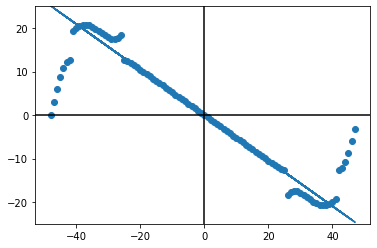

In [198]:
plt.scatter(compute_k(np.linalg.eig(global_CG(D, M, p_order))), np.linalg.eig(global_CG(D, M, p_order))[0].imag)
plt.plot(compute_k(np.linalg.eig(global_CG(D, M, p_order))), 
         - ((2 * np.pi) / L) * compute_k(np.linalg.eig(global_CG(D, M, p_order))))
plt.axhline(0, color='black')  
plt.axvline(0, color='black') 

plt.ylim(-25, 25)

### DG Dispersion w/ Centered Flux:

In [208]:
compute_k(np.linalg.eig(global_DG(D, M, p_order, L, quad_weights(GLL_points))))

array([-28.,  28., -29.,  29., -27.,  27., -30.,  30., -26.,  26., -31.,
        31., -25.,  25., -32.,  32., -33.,  33., -36.,  36., -34.,  34.,
       -39.,  39., -24.,  24., -35.,  35., -37.,  37., -38.,  38., -47.,
        47., -48.,  48., -46.,  46., -49.,  49., -45.,  45., -44.,  44.,
       -50.,  50., -43.,  43., -42.,  42., -51.,  51., -41.,  41., -24.,
        24., -23.,  23., -22.,  22., -52.,  52., -21.,  21., -20.,  20.,
       -19.,  19., -18.,  18., -17.,  17., -53.,  53., -16.,  16., -15.,
        15., -14.,  14., -13.,  13., -56.,   0., -12.,  12., -11.,  11.,
       -10.,  10.,  -1.,   1.,  -2.,   2.,  -8.,   8.,  -4.,   4.,  -7.,
         7.,  -5.,   5., -54.,  54.,  -9.,   9.,  -3.,   3., -55.,  55.,
        -6.,   6.])

In [207]:
np.linalg.eig(global_DG(D, M, p_order, L, quad_weights(GLL_points)))[0].imag

array([ 37.70111444, -37.70111444,  37.67507134, -37.67507134,
        37.53495527, -37.53495527,  37.44892155, -37.44892155,
        37.20528747, -37.20528747,  37.04159209, -37.04159209,
        36.75632553, -36.75632553,  36.50406647, -36.50406647,
        35.91988336, -35.91988336,  34.89026049, -34.89026049,
        35.39448386, -35.39448386,  35.7316419 , -35.7316419 ,
        36.24374123, -36.24374123,  35.02942885, -35.02942885,
        34.98872391, -34.98872391,  35.2897471 , -35.2897471 ,
        15.55937305, -15.55937305,  15.49153765, -15.49153765,
        15.4091181 , -15.4091181 ,  15.11699385, -15.11699385,
        15.11126183, -15.11126183,  14.71701462, -14.71701462,
        14.34239786, -14.34239786,  14.26184968, -14.26184968,
        13.76977995, -13.76977995,  13.10797173, -13.10797173,
        13.2570168 , -13.2570168 ,  12.73493569, -12.73493569,
        12.21307482, -12.21307482,  11.70540456, -11.70540456,
        11.57774969, -11.57774969,  11.26856076, -11.26

(-50.0, 50.0)

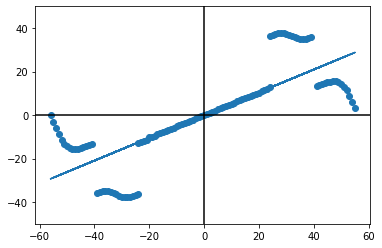

In [210]:
plt.scatter(compute_k(np.linalg.eig(global_DG(D, M, p_order, L, quad_weights(GLL_points)))), 
                      - np.linalg.eig(global_DG(D, M, p_order, L, quad_weights(GLL_points)))[0].imag)

plt.plot(compute_k(np.linalg.eig(global_DG(D, M, p_order, L, quad_weights(GLL_points)))), 
         ((2 * np.pi) / L) * compute_k(np.linalg.eig(global_DG(D, M, p_order, L, quad_weights(GLL_points)))))

plt.axhline(0, color='black')  
plt.axvline(0, color='black') 

plt.ylim(-50, 50)

### DG Dispersion w/ Upwind Flux:

In [24]:
def global_upwind_DG(D, M, p, L, quad_weights):
    
    array = np.zeros((M * (p + 1), M * (p + 1)))
    C = (L / (2 * M))
    row_i = 0
    col_i = 0
    
    for i in np.arange(M):
        if i == 0:
            array[row_i : row_i + (p+1), col_i : col_i + (p+1)] = (-D * (1 / C))
            
            # Right boundary correction:
            array[row_i + p, row_i + p] = (-D[-1, -1] * (1 / C)) - (0.80 * (1 / (quad_weights[-1] * C))) + (1 / (quad_weights[-1] * C))
            array[row_i + p, row_i + p + 1] = -(0.20 * (1 / (quad_weights[-1] * C)))
            
            # Left boundary correction:
            array[row_i, row_i] = (-D[0, 0] * (1 / C)) + (0.20 * (1 / (quad_weights[0] * C))) - (1 / (quad_weights[0] * C))
            
            # Periodic boundaries:
            array[0, -1] = (0.80 * (1 / (quad_weights[0] * C)))
            
        elif i == (M-1):
            array[row_i : row_i + (p+1), col_i : col_i + (p+1)] = (-D * (1 / C))
            
            # Left boundary correction:
            array[row_i, row_i] = (-D[0, 0] * (1 / C)) + (0.20 * (1 / (quad_weights[0] * C))) - (1 / (quad_weights[0] * C))
            array[row_i, row_i - 1] = (0.80 * (1 / (quad_weights[0] * C)))
            
            # Right boundary correction:
            array[row_i + p, row_i + p] = (-D[-1, -1] * (1 / C)) - (0.80 * (1 / (quad_weights[-1] * C))) + (1 / (quad_weights[-1] * C))
            
            # Periodic boundaries:
            array[-1, 0] = -(0.20 * (1 / (quad_weights[-1] * C)))
            
        else:
            array[row_i : row_i + (p+1), col_i : col_i + (p+1)] = (-D * (1 / C))
            
            # Right boundary correction:
            array[row_i + p, row_i + p] = (-D[-1, -1] * (1 / C)) - (0.80 * (1 / (quad_weights[-1] * C))) + (1 / (quad_weights[-1] * C))
            array[row_i + p, row_i + p + 1] = -(0.20 * (1 / (quad_weights[-1] * C)))
        
            # Left boundary correction:
            array[row_i, row_i] = (-D[0, 0] * (1 / C)) + (0.20 * (1 / (quad_weights[0] * C))) - (1 / (quad_weights[0] * C))
            array[row_i, row_i - 1] = (0.80 * (1 / (quad_weights[0] * C)))
        
        row_i = row_i + (p+1)
        col_i = col_i + (p+1)
        
    return(array)

In [25]:
compute_k(np.linalg.eig(global_upwind_DG(D, M, p_order, L, quad_weights(GLL_points))))

array([-31.,  31., -30.,  30., -29.,  29., -32.,  32., -28.,  28., -33.,
        33., -27.,  27., -34.,  34., -26.,  26., -25.,  25., -35.,  35.,
       -24.,  24., -39.,  39., -36.,  36., -38.,  38., -37.,  37., -53.,
        53., -54.,  54., -56., -55.,  55., -52.,  52., -51.,  51., -50.,
        50., -49.,  49., -48.,  48., -47.,  47., -46.,  46., -45.,  45.,
       -44.,  44., -43.,  43., -42.,  42., -41.,  41., -24.,  24., -23.,
        23., -22.,  22., -21.,  21., -20.,  20., -19.,  19., -18.,  18.,
       -17.,  17., -16.,  16., -15.,  15., -14.,  14., -13.,  13., -12.,
        12.,   0., -11.,  11., -10.,  10.,  -9.,   9.,  -8.,   8.,  -6.,
         6.,  -7.,   7.,  -3.,   3.,  -2.,   2.,  -5.,   5.,  -4.,   4.,
        -1.,   1.])

(-40.0, 40.0)

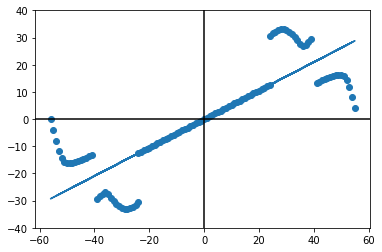

In [27]:
plt.scatter(compute_k(np.linalg.eig(global_upwind_DG(D, M, p_order, L, quad_weights(GLL_points)))), 
                      - np.linalg.eig(global_upwind_DG(D, M, p_order, L, quad_weights(GLL_points)))[0].imag)

plt.plot(compute_k(np.linalg.eig(global_upwind_DG(D, M, p_order, L, quad_weights(GLL_points)))), 
         ((2 * np.pi) / L) * compute_k(np.linalg.eig(global_upwind_DG(D, M, p_order, L, quad_weights(GLL_points)))))

plt.axhline(0, color='black')  
plt.axvline(0, color='black') 

plt.ylim(-40, 40)